# Scene Dimensionality Analysis

Using the Standard Background Dataset

# Load the libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Constants
DATASET = "./dataset"
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [3]:
# Load class labels
class_dict = pd.read_csv(os.path.join(DATASET, "labels_class_dict.csv"))
class_names = class_dict['class_names'].tolist()

In [4]:
# Load dataset metadata
metadata = pd.read_csv(os.path.join(DATASET, "metadata.csv"))

In [5]:
# Load Images and Masks
def load_data(metadata_df, dataset_path):
    images, masks = [], []
    
    for _, row in metadata_df.iterrows():
        img_path = os.path.join(dataset_path, row["image_path"])
        mask_path = os.path.join(dataset_path, row["label_colored_path"])  # Use colored masks
        
        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found for {row['image_path']}, skipping...")
            continue
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Failed to load image {row['image_path']}, skipping...")
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0  # Normalize
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Failed to load mask {row['label_colored_path']}, skipping...")
            continue
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # Ensure mask is correctly formatted
        mask = mask.astype(np.uint8)  # Ensure integer values
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [6]:
# Load dataset
X, y = load_data(metadata, DATASET)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
# Normalize class labels to start from 0
unique_labels = np.unique(y_train)
label_mapping = {old_label: idx for idx, old_label in enumerate(unique_labels)}
y_train = np.vectorize(label_mapping.get)(y_train).astype(np.int32)
y_val = np.vectorize(label_mapping.get)(y_val).astype(np.int32)

# Ensure the correct shape (batch_size, height, width, 1)
y_train = y_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
y_val = y_val.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

NUM_CLASSES = len(unique_labels)  # Use correct number of classes

In [8]:
# Debug: Print dataset information
print(f"Dataset loaded: {len(X_train)} training images, {len(X_val)} validation images")
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Remapped unique values in y_train: {np.unique(y_train)}")

Dataset loaded: 643 training images, 72 validation images
Shape of X_train: (643, 256, 256, 3), Shape of y_train: (643, 256, 256, 1)
Remapped unique values in y_train: [0 1 2 3 4 5 6 7 8]


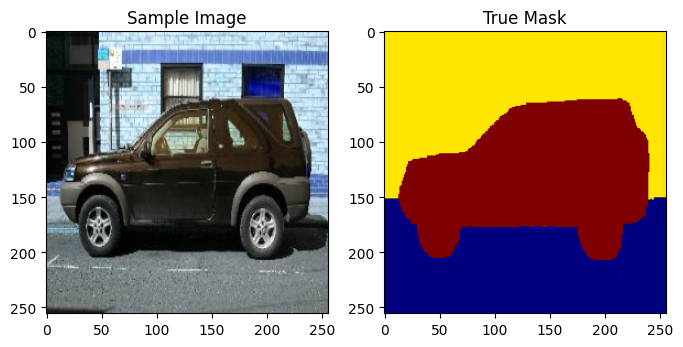

In [9]:
# Debug: Show a random image and its mask before training
index = np.random.randint(0, len(X_train))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[index])
plt.title("Sample Image")
plt.subplot(1, 2, 2)
plt.imshow(y_train[index].squeeze(), cmap="jet")
plt.title("True Mask")
plt.show()

In [10]:
# U-Net Model
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)  # Ensure correct output shape
    
    model = keras.Model(inputs, outputs)
    return model

In [11]:
# Compile Model
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step - accuracy: 0.1735 - loss: 2.0770 - val_accuracy: 0.2285 - val_loss: 1.9149
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 245s 6s/step - accuracy: 0.2295 - loss: 1.8507 - val_accuracy: 0.2667 - val_loss: 1.8289
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - accuracy: 0.3214 - loss: 1.6878 - val_accuracy: 0.3930 - val_loss: 1.5180
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - accuracy: 0.4360 - loss: 1.4898 - val_accuracy: 0.4277 - val_loss: 1.5032
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.4696 - loss: 1.4337 - val_accuracy: 0.4934 - val_loss: 1.3881
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 249s 6s/step - accuracy: 0.5459 - loss: 1.2584 - val_accuracy: 0.5190 - val_loss: 1.2623
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 250s 6s/step - accuracy: 0.5833 - loss: 1.1910 - val_accuracy: 0.5523 - val_loss: 1.2117
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.5903 - loss: 1.1673 - val_accuracy: 0.5662 - v

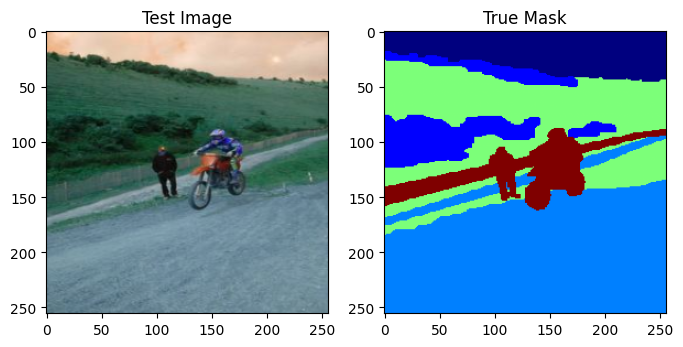

In [36]:
# Predict and show the result
index = np.random.randint(0, len(X_val))
test_img = X_val[index]
true_mask = y_val[index]

# Show the test & true mask
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Test Image")
plt.subplot(1, 2, 2)
plt.imshow(true_mask.squeeze(), cmap="jet")
plt.title("True Mask")
plt.show()

In [37]:
# Ensure correct input shape for prediction
predicted_mask = model.predict(test_img[np.newaxis, ...])[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


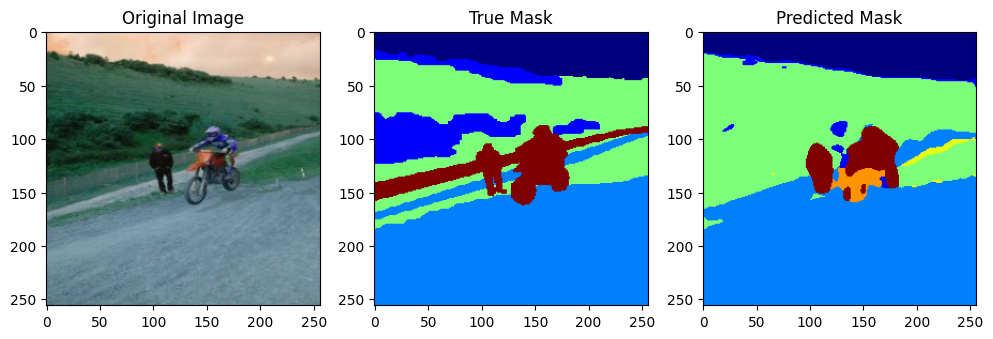

In [38]:
# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_img)
ax[0].set_title("Original Image")
ax[1].imshow(true_mask.squeeze(), cmap="jet")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="jet")
ax[2].set_title("Predicted Mask")
plt.show()

In [15]:
# Load the dataset
meta_data = pd.read_csv(DATASET + "/metadata.csv")

print(meta_data.head())
# Perform 85/15 split for train / test
test = meta_data.sample(frac=0.15, random_state=42)
train = meta_data.drop(test.index)

   image_id  image_width  image_height          image_path  \
0        47          320           240  images/0000047.jpg   
1        51          320           240  images/0000051.jpg   
2        59          320           240  images/0000059.jpg   
3        72          320           240  images/0000072.jpg   
4        87          320           240  images/0000087.jpg   

           label_colored_path              label_layers_path  \
0  labels_colored/0000047.png  labels_raw/0000047.layers.txt   
1  labels_colored/0000051.png  labels_raw/0000051.layers.txt   
2  labels_colored/0000059.png  labels_raw/0000059.layers.txt   
3  labels_colored/0000072.png  labels_raw/0000072.layers.txt   
4  labels_colored/0000087.png  labels_raw/0000087.layers.txt   

               label_regions_path              label_surfaces_path  \
0  labels_raw/0000047.regions.txt  labels_raw/0000047.surfaces.txt   
1  labels_raw/0000051.regions.txt  labels_raw/0000051.surfaces.txt   
2  labels_raw/0000059.regions.tx

In [16]:
class_dict = pd.read_csv(DATASET + '/labels_class_dict.csv')
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
Class RGB values:  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]
